## 1. Importing Necessary Libraries

### Description
In this section, we import all the essential libraries required for data processing, model building, training, and evaluation. Each library plays a specific role in the overall pipeline of this project.

- **NumPy (`np`) and Pandas (`pd`):** These are fundamental for handling numerical data and structured dataframes, respectively.
- **Matplotlib (`plt`):** Used for creating visualizations, particularly for plotting metrics and model performance.
- **PyTorch (`torch`, `nn`, etc.):** The core deep learning library used for building, training, and evaluating neural networks.
- **Torchvision (`transforms`, `make_grid`):** Provides tools and utilities specifically designed for computer vision tasks.
- **Scikit-learn (`train_test_split`):** Helps in splitting the dataset into training and testing sets, among other utilities.
- **PIL and OpenCV (`Image`, `cv2`):** Libraries for handling image processing tasks, such as loading, transforming, and augmenting images.
- **Other Utilities:**
  - **`time`, `copy`, `random`, `os`, `itertools`:** Standard Python libraries for various utilities like timing code execution, copying objects, handling random seeds, interacting with the file system, and working with iterators.
  - **`torchsummary`:** Provides a summary of the model architecture, useful for understanding the layer-by-layer structure of the network.
  - **`random_split`:** A utility from PyTorch for splitting datasets into training and validation subsets.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision.utils import make_grid as vutils
from torchvision import transforms
from torchvision import models
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ExponentialLR
import time
import copy
import random
import os
import cv2
import torch.optim as optim
from torchsummary import summary
import itertools
from PIL import Image
from torch.utils.data import random_split


c:\Users\ornor\AppData\Local\Programs\Python\Python312\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


## 2. Setting Up Environment

### Description
This section involves setting up the environment and initializing key hyperparameters for the model training process.

- **Random Seed Initialization:**
  - To ensure reproducibility, a fixed seed (`42`) is used for various random number generators across different libraries, including Python's `random`, `NumPy`, and PyTorch. 
  - The `PYTHONHASHSEED` environment variable is also set to ensure consistent hash values, and PyTorch's deterministic setting ensures that operations have deterministic outputs.
  
- **Device Configuration:**
  - The code checks for the availability of a GPU. If a GPU is available, it sets the device to `"cuda"`, otherwise it defaults to `"cpu"`.
  
- **Dataset Loading:**
  - The CSV files `train_new.csv` and `test_new.csv` are loaded into Pandas DataFrames (`csv_combine` and `csv_test`), which contain information about the images and their corresponding labels.
  
- **Image Dimension:**
  - The variable `image_dim` is set to `224`, indicating that the images will be resized to 224x224 pixels, a common input size for models like ResNet and Vision Transformers.


In [5]:
seed=42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
device = "cuda" if torch.cuda.is_available() else "cpu"
lr=0.001
epochs=16
batch_size=16
gamma = 0.5
csv_train = pd.read_csv("train_new.csv")
csv_test = pd.read_csv("test_new.csv")
image_dim = 224

## 3. Mapping Class IDs to Indices

### Description
In this section, we create mappings between class labels and numeric indices, which are essential for the model to process categorical data during training and evaluation.

- **Class ID Mapping (`class_id`):**
  - The `class_id` dictionary is created to map each unique class label in the training dataset (`csv_train`) to a unique integer index. 
  - The variable `nclass` is set to the total number of unique classes, which is calculated as the number of unique class IDs.

- **Original Class Mapping (`class_original`):**
  - The `class_original` dictionary is used to map the integer indices back to the original class labels, specifically for the test dataset (`csv_test`). This is useful for interpreting the model's predictions in terms of the original class labels.



In [6]:
class_id = {}
for i,cl in enumerate(csv_train.class_id.unique()):
    class_id[cl] = i
nclass = i+1

class_original = {}
for i,cl in enumerate(csv_test.class_id.unique()):
    class_original[i] = cl

In [7]:
train_size = len(csv_train)
test_size = len(csv_test)
print("train size:", train_size)
print("test size:", test_size)

train size: 13631
test size: 1721


## 5. Previewing the Training Dataset

### Description
Before proceeding with data preprocessing or model training, it's useful to inspect the first few rows of the training dataset. This helps ensure that the data has been loaded correctly and that the columns are as expected.

- **Previewing the Data (`csv_train.head()`):**
  - The `head()` function is used to display the first 5 rows of the `csv_train` DataFrame.
  - This provides a quick look at the structure of the data, including the class IDs, image paths, and any other relevant features.



In [8]:
csv_train.head()

Unnamed: 0                binomial                   country  \
0           0  Agkistrodon contortrix  United States of America   
1           1  Agkistrodon contortrix  United States of America   
2           2  Agkistrodon contortrix  United States of America   
3           3  Agkistrodon contortrix  United States of America   
4           4  Agkistrodon contortrix  United States of America   

       continent        genus     family                              UUID  \
0  North America  Agkistrodon  Viperidae  20e23008100d4e249fd757c11fe059fe   
1  North America  Agkistrodon  Viperidae  0c6d14f33f404013ab116ab09880c523   
2  North America  Agkistrodon  Viperidae  3a31a32de0434653b4a82a30806f7a6d   
3  North America  Agkistrodon  Viperidae  1c5a3b2953c84d698fad8a40db91323e   
4  North America  Agkistrodon  Viperidae  e10c99a58c2546dab2c0d998de1f7c1b   

   class_id        snake_sub_family  poisonous         X         Y    height  \
0        18  Agkistrodon contortrix          1  0.507412  0.546939  0.916220   
1        18  Agkistrodon contortrix          1  0.503115  0.392086  0.835316   
2        18  Agkistrodon contortrix          1  0.353031  0.573312  0.652700   
3        18  Agkistrodon contortrix          1  0.436368  0.447794  0.918880   
4        18  Agkistrodon contortrix          1  0.512284  0.519067  0.923202   

      width  
0  0.951425  
1  0.965363  
2  0.709286  
3  0.834457  
4  0.631036

In [9]:
csv_test.head()

Unnamed: 0                binomial                   country  \
0           0  Agkistrodon contortrix  United States of America   
1           1  Agkistrodon contortrix  United States of America   
2           2  Agkistrodon contortrix  United States of America   
3           3  Agkistrodon contortrix  United States of America   
4           4  Agkistrodon contortrix  United States of America   

       continent        genus     family                              UUID  \
0  North America  Agkistrodon  Viperidae  ca23ee722e5e4b6ca4b130291b8428f1   
1  North America  Agkistrodon  Viperidae  23dfe346fcbf40e7a465b0febf3620be   
2  North America  Agkistrodon  Viperidae  2c96953bd06645bdbfa87b180eb72b0f   
3  North America  Agkistrodon  Viperidae  e2bcec60b133466380d5c253088765ae   
4  North America  Agkistrodon  Viperidae  fd6a488d065e47978c9996734fc1732c   

   class_id        snake_sub_family  poisonous  
0        18  Agkistrodon contortrix          1  
1        18  Agkistrodon contortrix          1  
2        18  Agkistrodon contortrix          1  
3        18  Agkistrodon contortrix          1  
4        18  Agkistrodon contortrix          1

## 6. Analyzing the Distribution of Species in the Training Dataset

### Description
This section provides an analysis of the distribution of species within the training dataset. Specifically, it prints out the species that have more than 170 images and counts the total number of such species. It also flags species with fewer than 170 images for potential exclusion from the training process.
  
- **Species Filtering:**
  - The loop iterates over each unique species in the `binomial` column of `csv_train` and counts the number of images associated with that species.
  - Species with more than 170 images are printed, and the total count of these species is accumulated.
  - Species with fewer than 170 images are flagged with the message "****** take out:" indicating that they might be candidates for exclusion from the training process due to insufficient data.
  


In [10]:
print("Species".ljust(97)+"No Of Images")
a=0
for i in csv_train.binomial.unique():
    s = sum(csv_train.binomial == i)
    if s>170:
        print("{} {}".format(i.ljust(100),s))
        a+=1
    else:
        print("****** take out:",i)
print('number of species: ',a)

Species                                                                                          No Of Images
Agkistrodon contortrix                                                                               180
Agkistrodon piscivorus                                                                               200
Ahaetulla nasuta                                                                                     199
Arizona elegans                                                                                      181
Atractus crassicaudatus                                                                              187
Austrelaps superbus                                                                                  201
Bitis gabonica                                                                                       186
Bogertophis subocularis                                                                              197
Boiga irregularis                                 

In [11]:
print('number of species: ',a)

number of species:  74


## 7. Defining Pre-Transformation for Images

### Description
In this section, we define a set of pre-processing transformations that will be applied to the images before they are fed into the model. These transformations are crucial for standardizing the input data and preparing it in the format required by the neural network.
  
- **Transformation Pipeline:**
  - **`transforms.ToTensor()`**: Converts the image from a PIL Image or a NumPy array to a PyTorch tensor. This step is necessary because PyTorch models require input in the form of tensors.
  - **`transforms.Resize(size=(image_dim, image_dim))`**: Resizes the image to the dimensions specified by `image_dim` (in this case, 224x224 pixels). This ensures that all images fed into the model have consistent dimensions, which is critical for batch processing in deep learning models.
  


In [12]:
pre_transformation = {
    "pre_transformation_image": transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=(image_dim,image_dim))
        ])
}

## 8. Defining the `pre_Dataset_receiver` Custom Dataset Class

### Description
In this section, we define a custom dataset class `pre_Dataset_receiver` that inherits from PyTorch's `Dataset` class. This custom class is designed to handle the specific requirements of our snake species classification task, including loading images, applying transformations, and managing bounding box coordinates.

### Class Breakdown:

- **`__init__` Method:**
  - **Parameters:**
    - `csv`: The DataFrame containing the image metadata, including class IDs and bounding box coordinates.
    - `traindir`: The directory where the training images are stored.
    - `device`: The device on which the data should be processed (e.g., "cpu" or "cuda").
    - `transform`: A dictionary of transformations to be applied to the images.
    - `class_id`: A dictionary mapping class labels to integer indices.
  - **Purpose:**
    - Initializes the dataset with the provided CSV data, image directory, device, transformations, and class ID mappings.

- **`__len__` Method:**
  - **Returns:**
    - The length of the dataset, which is the number of entries in the CSV file.

- **`__getitem__` Method:**
  - **Parameters:**
    - `idx`: The index of the data point to retrieve.
  - **Returns:**
    - A tuple containing the transformed image tensor and the corresponding class label tensor.

### Detailed Explanation of `__getitem__`:
- **Image Loading:**
  - The image is loaded using the `Image.open()` function from the PIL library. The file path is constructed using the class ID, UUID from the CSV, and the `traindir`.
  
- **Bounding Box Handling:**
  - If bounding box coordinates (`X`, `Y`, `width`, `height`) are available, the image is cropped to the bounding box area before transformation.

- **Transformation and Return:**
  - The cropped or full image is transformed using the predefined transformations (e.g., resizing, converting to tensor).

- **Error Handling:**
  - If an error occurs while processing the bounding box, the full image is transformed and returned instead of the cropped version.


In [13]:
class pre_Dataset_receiver(Dataset):
    def __init__(self, csv, traindir, device, transform, class_id):
        self.csv = csv
        self.traindir = traindir
        self.transform =transform
        self.device = device
        self.class_id = class_id
    def __len__(self):
        return len(self.csv)
    def __getitem__(self, idx):

        csv = self.csv.iloc[[idx]]
        cl = csv["class_id"].values[0]
        location = self.traindir + "/" + str(cl) + "/" + csv["UUID"].values[0] + ".jpg"
        bbox = []
        image = Image.open(location)
        key = str(cl) + csv["UUID"].values[0]

        image = np.array(image)


        # now [x center , y center , width , height]
        shape = image.shape[0]
        try:
            x,y,width,height = [csv.X, csv.Y, csv.width, csv.height] * shape
            x0 ,y0 = int(x-(width/2)) ,int(y-(height/2))
            x1 ,y1 = int(x+(width/2)) ,int(y+(height/2))

            if x0 < 0:
                x0=0
            if x1 > shape:
                x1 = shape
            if y0 < 0:
                y0 = 0
            if y1 > shape:
                y1 = shape

            processed_image = self.transform["pre_transformation_image"](image[y0:y1, x0:x1])
            return processed_image, torch.tensor(self.class_id[cl])
        except:
            processed_image = self.transform["pre_transformation_image"](image)
            return processed_image, torch.tensor(self.class_id[cl])


In [16]:
pre_train_dataset = pre_Dataset_receiver(csv_train, "train", device, pre_transformation, class_id)

pre_train_dataloader = DataLoader(pre_train_dataset, batch_size = 64)

## 9. Computing Dataset Mean and Standard Deviation & Defining Final Transformation

### Description
In this section, we compute the mean and standard deviation of the images in the dataset using a data loader. These statistics are crucial for normalizing the dataset, which helps the model converge faster and perform better.

### Detailed Explanation:

- **Function `compute_mean_std`:**
  - This function calculates the mean and standard deviation of the images across all batches in the dataset.
  - **Parameters:**
    - `data_loader`: A PyTorch DataLoader that iterates over the dataset, yielding batches of images.
  - **Returns:**
    - `mean`: The computed mean of the dataset.
    - `std`: The computed standard deviation of the dataset.

- **Defining the Transformation Pipeline:**
  - After computing the mean and standard deviation, these values are used in a `transforms.Normalize` operation to normalize the images in the dataset.
  - **Transformation Pipeline:**
    - **`ToTensor`**: Converts images to PyTorch tensors.
    - **`Resize`**: Resizes images to the specified dimensions (`image_dim`).
    - **`Normalize`**: Normalizes the images using the computed mean and standard deviation.



In [17]:
def compute_mean_std(data_loader):
    # Initialize variables to compute mean and std
    mean = 0.
    std = 0.
    num_batches = 0
    for images, _ in data_loader:
        # Compute the mean and std for the current batch
        batch_mean = images.mean(dim=[0, 2, 3])
        batch_std = images.std(dim=[0, 2, 3])
        mean += batch_mean
        std += batch_std
        num_batches += 1



    # Compute the final mean and std
    mean /= num_batches
    std /= num_batches

    return mean, std

mean_clc, std_clc = compute_mean_std(pre_train_dataloader)
print(f"Mean: {mean_clc}")
print(f"Std: {std_clc}")

Mean: tensor([0.4624, 0.4334, 0.3666])
Std: tensor([0.2366, 0.2259, 0.2223])


In [18]:

mean = mean_clc
std = std_clc

transformation = {
    "transformation_image": transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=(image_dim,image_dim)),
            transforms.Normalize(mean,std)
        ])
}


## 10. Defining the `Dataset_receiver` Custom Dataset Class with Augmentation

### Description
This section defines the `Dataset_receiver` class, a custom dataset class that extends PyTorch's `Dataset` class. This class is designed to load images, apply transformations, and optionally apply data augmentation. The class handles images with bounding boxes and returns them as tensors along with their corresponding class labels.

### Class Breakdown:

- **`__init__` Method:**
  - **Parameters:**
    - `csv`: The DataFrame containing image metadata, such as class IDs and bounding box coordinates.
    - `traindir`: The directory path where the training images are stored.
    - `device`: The device used for processing (e.g., "cpu" or "cuda").
    - `transform`: A dictionary containing the transformation pipeline.
    - `class_id`: A dictionary that maps class labels to integer indices.
    - `aug`: (Optional) Augmentation function to apply additional transformations to the images.
  - **Purpose:**
    - Initializes the dataset with the provided CSV data, image directory, device, transformations, class ID mappings, and optional augmentation.

- **`__len__` Method:**
  - **Returns:**
    - The total number of images in the dataset.

- **`__getitem__` Method:**
  - **Parameters:**
    - `idx`: The index of the data point to retrieve.
  - **Returns:**
    - A tuple containing the transformed image tensor and the corresponding class label tensor.
  - **Purpose:**
    - Loads the image at the specified index, applies any augmentations and transformations, and returns the processed image and its class label.

### Detailed Explanation of `__getitem__`:
- **Image Loading:**
  - The image is loaded using `Image.open()` based on the file path constructed from the class ID, UUID, and the `traindir`.

- **Data Augmentation:**
  - If an augmentation function is provided (`self.aug`), it is applied to the image before any further processing.
  
- **Bounding Box Handling:**
  - The bounding box coordinates (if provided) are used to crop the image. The coordinates are scaled based on the image dimensions, and any out-of-bound coordinates are adjusted to stay within the image limits.
  - **Error Handling:** If an error occurs during bounding box processing, the full image is used instead of the cropped version.

- **Transformation and Return:**
  - The final transformation pipeline (`transformation_image`) is applied to the image, and the transformed image is returned along with the class label as tensors.


In [20]:
class Dataset_receiver(Dataset):
    def __init__(self, csv, traindir, device, transform, class_id, aug = None):
        self.csv = csv
        self.traindir = traindir
        self.transform =transform
        self.device = device
        self.class_id = class_id
        self.aug = aug
    def __len__(self):
        return len(self.csv)
    def __getitem__(self, idx):

        csv = self.csv.iloc[[idx]]
        cl = csv["class_id"].values[0]
        location = self.traindir + "/" + str(cl) + "/" + csv["UUID"].values[0] + ".jpg"
        bbox = []
        image = Image.open(location)
        key = str(cl) + csv["UUID"].values[0]
        if self.aug != None:
            image = self.aug(image)

        image = np.array(image)


        # now [x center , y center , width , height]
        shape = image.shape[0]
        try:
            x,y,width,height = [csv.X, csv.Y, csv.width, csv.height] * shape
            x0 ,y0 = int(x-(width/2)) ,int(y-(height/2))
            x1 ,y1 = int(x+(width/2)) ,int(y+(height/2))

            if x0 < 0:
                x0=0
            if x1 > shape:
                x1 = shape
            if y0 < 0:
                y0 = 0
            if y1 > shape:
                y1 = shape

            processed_image = self.transform["transformation_image"](image[y0:y1, x0:x1])
            return processed_image, torch.tensor(self.class_id[cl])
        except:
            processed_image = self.transform["transformation_image"](image)
            return processed_image, torch.tensor(self.class_id[cl])


## 11. Defining Data Augmentation and Initializing Datasets and DataLoaders

### Description
In this section, we define the data augmentation transformations, initialize the training and test datasets, and create DataLoaders to handle the data efficiently during training and evaluation. Data augmentation is a common technique used to artificially increase the diversity of the training data, although in this case, the augmentation pipeline is currently empty.

### Detailed Explanation:

- **Data Augmentation Pipeline (`transform_aug`):**
  - **Purpose:** Data augmentation is typically used to introduce variability into the training data, which can help improve the model's generalization. However, in this case, the augmentation pipeline is defined but left empty, meaning no additional transformations are applied beyond the standard preprocessing steps.
  - **Customization:** The augmentation pipeline can be customized by adding transformations such as random cropping, flipping, rotation, or color jittering to enhance the robustness of the model.


In [21]:
transform_aug = transforms.Compose([

])

train_dataset = Dataset_receiver(csv_train, "train", device, transformation, class_id, transform_aug)
test_dataset = Dataset_receiver(csv_test, "test", device, transformation, class_id)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)


## 12. Denormalizing and Visualizing Training Batches

### Description
In this section, we define a function to denormalize image batches that have been normalized using the dataset mean and standard deviation. We then use this function to visualize a batch of images from the training dataset. This step is important for interpreting the images in their original form after the model has been trained on normalized data.

### Detailed Explanation:

- **Function `denormalize_batch`:**
  - **Parameters:**
    - `batch`: The batch of images that has been normalized.
    - `mean`: The mean used for normalization, which is reshaped to match the batch dimensions.
    - `std`: The standard deviation used for normalization, also reshaped to match the batch dimensions.
  - **Returns:**
    - `denormalized_batch`: The batch of images after reversing the normalization process.
  - **Purpose:**
    - This function reverses the normalization by multiplying the batch by the standard deviation and then adding the mean, effectively restoring the original pixel values.

In [22]:
def denormalize_batch(batch, mean, std):
    # Reshape mean and std to match the dimensions of the batch
    mean = mean.view(1, 3, 1, 1)  # Reshape to [1, 3, 1, 1]
    std = std.view(1, 3, 1, 1)    # Reshape to [1, 3, 1, 1]

    # Denormalize the batch
    denormalized_batch = batch * std + mean

    return denormalized_batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


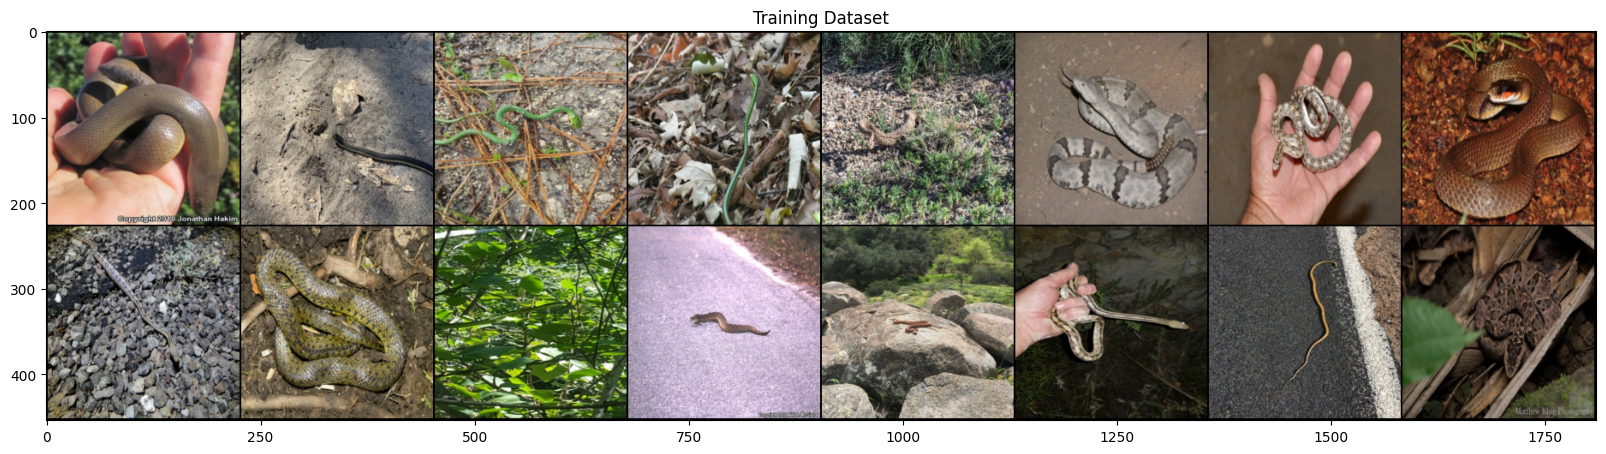

torch.Size([16, 3, 224, 224])
tensor([15, 68, 55, 48, 23, 25,  3, 31,  7,  4, 47, 22, 27,  7, 33, 10])
torch.Size([16])
tensor([122, 690, 495, 384, 165, 175,  39, 195,  65,  48, 383, 163, 185,  65,
        216,  87])
torch.Size([16])


In [23]:
a,clas = next(iter(train_dataloader))
b = denormalize_batch(a, mean, std)
original_class = torch.tensor([class_original[int(i)] for i in clas])
plt.figure(figsize=(20,20))
plt.title("Training Dataset")
plt.imshow(torch.swapdims(torch.swapdims(vutils(b,8,2),0,2),0,1))
plt.show()
print(a.shape)

print(clas)
print(clas.shape)

print(original_class)
print(original_class.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


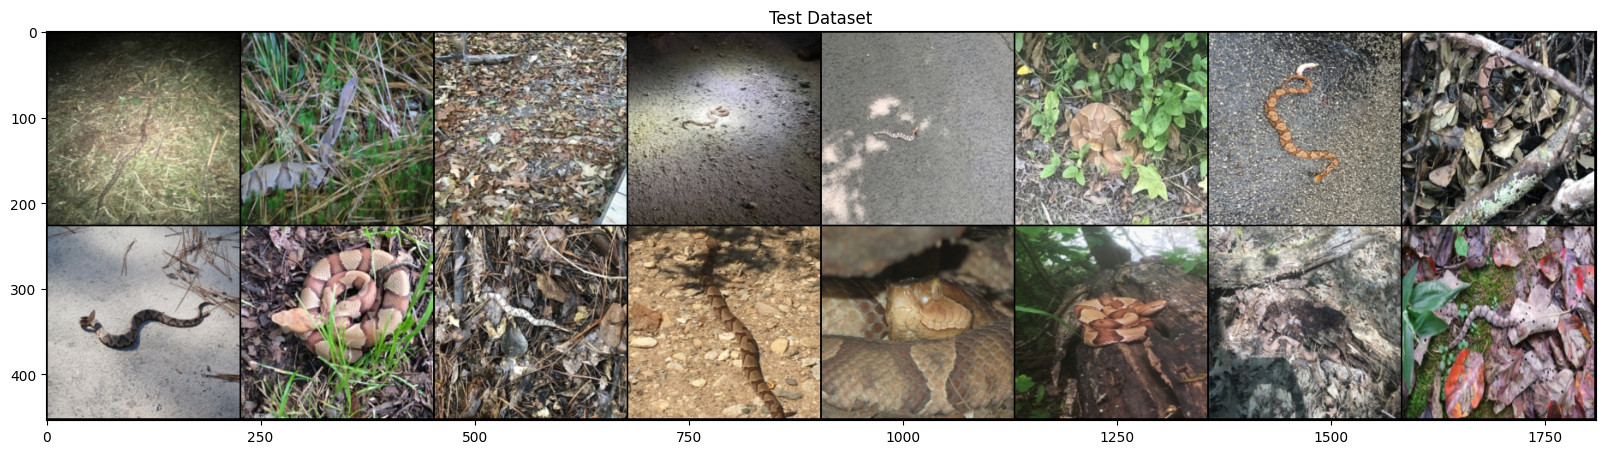

tensor([18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18])
torch.Size([16])


In [24]:
c,test_clas = next(iter(test_dataloader))
d = denormalize_batch(c, mean, std)
test_original_class = torch.tensor([class_original[int(i)] for i in test_clas])
plt.figure(figsize=(20,20))
plt.title("Test Dataset")
plt.imshow(torch.swapdims(torch.swapdims(vutils(d,8,2),0,2),0,1))
plt.show()
print(test_original_class)
print(test_original_class.shape)

In [25]:
id_name = list(class_id.values())

## 13. Defining the `Classifier` Class for Model Training and Evaluation

### Description
The `Classifier` class is a general-purpose framework for training and evaluating deep learning models. It includes methods for model initialization, training, evaluation, saving/loading models, and plotting results. The class also implements early stopping and learning rate scheduling to optimize the training process.

### Class Breakdown:

- **`__init__` Method:**
  - **Parameters:**
    - `model_path` (str): Path where the trained model will be saved.
    - `n_classes` (int): Number of output classes for the model.
    - `criterion` (torch.nn.Module): Loss function to optimize.
    - `lr` (float): Learning rate for the optimizer.
    - `batch_size` (int): Number of samples per batch.
    - `scheduler_gamma` (float): Factor by which the learning rate is multiplied at each step of the scheduler.
    - `early_stopping_patience` (int): Number of epochs with no improvement in validation accuracy before stopping training early.

- **`init_model` Method:**
  - **Purpose:**
    - Placeholder method for initializing the model architecture. This method must be implemented in any subclass of `Classifier` to define the specific model architecture.

- **`get_trainable_parameters` Method:**
  - **Returns:**
    - List of trainable parameters in the model.

- **`train` Method:**
  - **Parameters:**
    - `train_loader` (DataLoader): DataLoader for the training dataset.
    - `eval_loader` (DataLoader): DataLoader for the validation or test dataset.
    - `n_epochs` (int): Number of epochs to train for.
    - `mode` (str): Either 'train-validation' or 'train-test' to specify the evaluation mode.


- **`evaluate` Method:**
  - **Parameters:**
    - `loader` (DataLoader): DataLoader for the dataset to be evaluated.
  - **Returns:**
    - Tuple containing the evaluation loss and accuracy.

- **`save_model` Method:**
  - **Purpose:**
    - Saves the trained model's state to the specified path.

- **`load_model` Method:**
  - **Purpose:**
    - Loads a saved model's state from the specified path.

- **`plot_results` Method:**
  - **Parameters:**
    - `mode` (str): Either 'train-validation' or 'train-test' to specify the evaluation mode.

- **`unfreeze_model` Method:**
  - **Purpose:**
    - Unfreezes all layers of the model, making them trainable for fine-tuning purposes.


In [26]:
class Classifier:
    def __init__(self, model_path, n_classes, criterion, lr, batch_size, scheduler_gamma=0.9, early_stopping_patience=3):
        """
        Initializes the Classifier with the model, optimizer, scheduler, and early stopping criteria.

        Args:
            model_path (str): Path to save the model.
            n_classes (int): Number of output classes.
            criterion (torch.nn.Module): Loss function.
            lr (float): Learning rate.
            batch_size (int): Size of each batch.
            scheduler_gamma (float): Multiplicative factor for learning rate decay.
            early_stopping_patience (int): Number of epochs with no improvement before stopping.
        """
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.n_classes = n_classes
        self.lr = lr
        self.criterion = criterion
        self.model = self.init_model().to(self.device)

        self.optimizer = torch.optim.Adam(self.get_trainable_parameters(), lr=lr)
        # Initialize ExponentialLR scheduler
        self.scheduler = lr_scheduler.ExponentialLR(self.optimizer, gamma=scheduler_gamma)
        self.batch_size = batch_size
        self.model_path = model_path
        self.early_stopping_patience = early_stopping_patience

        # Store training and validation history
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    def init_model(self):
        """
        Initializes the model. Must be implemented in the subclass.
        """
        raise NotImplementedError("Subclasses should implement this method.")

    def get_trainable_parameters(self):
        """
        Returns a list of trainable parameters in the model.

        Returns:
            list: Trainable parameters.
        """
        return [param for param in self.model.parameters() if param.requires_grad]

    def train(self, train_loader, eval_loader, n_epochs=10, mode='train-validation'):
        """
        Trains the classifier for a specified number of epochs.

        Args:
            train_loader: DataLoader for the training data.
            eval_loader: DataLoader for validation or test data.
            n_epochs: Number of epochs to train for.
            mode: Either 'train-validation' or 'train-test' to specify the evaluation mode.
        """
        best_accuracy = 0.0
        patience_counter = 0

        for epoch in range(n_epochs):
            # Training phase
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_accuracy = 100 * correct / total
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)

            print(f"Epoch [{epoch+1}/{n_epochs}] - Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

            # Evaluation phase
            eval_loss, eval_accuracy = self.evaluate(eval_loader)
            self.val_losses.append(eval_loss)
            self.val_accuracies.append(eval_accuracy)

            print(f" - {'Validation' if mode == 'train-validation' else 'Test'} Loss: {eval_loss:.4f}, {'Validation' if mode == 'train-validation' else 'Test'} Accuracy: {eval_accuracy:.2f}%")

            # Early stopping logic
            if eval_accuracy > best_accuracy:
                best_accuracy = eval_accuracy
                patience_counter = 0
                self.save_model()
            else:
                patience_counter += 1

            if patience_counter >= self.early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs. Best Accuracy: {best_accuracy:.2f}%")
                break

            # Step the scheduler to decay the learning rate
            self.scheduler.step()

        # Plot the training and evaluation metrics
        self.plot_results(mode)

    def evaluate(self, loader):
        """
        Evaluates the model on the provided data.

        Args:
            loader: DataLoader for the evaluation data.

        Returns:
            tuple: Evaluation loss and accuracy.
        """
        self.model.eval()
        cumulative_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                cumulative_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        eval_loss = cumulative_loss / len(loader)
        accuracy = 100 * correct / total
        return eval_loss, accuracy

    def save_model(self):
        """
        Saves the model's state to the specified path.
        """
        torch.save(self.model.state_dict(), self.model_path)
        print(f"Model saved to {self.model_path}.")

    def load_model(self):
        """
        Loads the model's state from the specified path.
        """
        self.model.load_state_dict(torch.load(self.model_path))
        self.model.eval()

    def plot_results(self, mode):
        """
        Plots the training and evaluation metrics.

        Args:
            mode: Either 'train-validation' or 'train-test' to specify the evaluation mode.
        """
        epochs_range = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, self.train_losses, label='Training Loss')
        plt.plot(epochs_range, self.val_losses, label=f"{'Validation' if mode == 'train-validation' else 'Test'} Loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, self.train_accuracies, label='Training Accuracy')
        plt.plot(epochs_range, self.val_accuracies, label=f"{'Validation' if mode == 'train-validation' else 'Test'} Accuracy")
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def unfreeze_model(self):
        """
        Unfreezes all layers of the model for fine-tuning.
        """
        for param in self.model.parameters():
            param.requires_grad = True


## 14. Defining the `VitClassifier` Class for Vision Transformer (ViT) Model

### Description
The `VitClassifier` class is a specific implementation of the `Classifier` base class tailored for the Vision Transformer (ViT) model. It utilizes the `dinov2_vits14` architecture from Facebook Research's DINOv2 project. This class customizes the model initialization, focusing on fine-tuning only the classification head while keeping the rest of the model layers frozen.

### Class Breakdown:

- **`__init__` Method:**
  - **Parameters:**
    - `model_path` (str): Path to save/load the model.
    - `n_classes` (int): Number of output classes for the model.
    - `criterion` (torch.nn.Module): Loss function to optimize.
    - `lr` (float): Learning rate for the optimizer.
    - `batch_size` (int): Number of samples per batch.
    - `scheduler_gamma` (float): Gamma value for learning rate decay in the scheduler.

- **`init_model` Method:**
  - **Purpose:**
    - This method loads the pre-trained ViT model (`dinov2_vits14`) and freezes its layers except for the newly added classification head, which is customized to the specific number of output classes.
    - **Implementation Details:**
      - **Loading the Model:** The `torch.hub.load` function is used to load the pre-trained Vision Transformer model.
      - **Freezing Layers:** All layers of the base model are frozen by setting `param.requires_grad = False`, ensuring that only the classification head is trainable.
      - **Classifier Head:** A custom classifier head is added on top of the base model. It consists of two linear layers with ReLU activation in between.
      - **Weight Initialization:** The `_initialize_weights` method is defined to initialize the weights of the linear layers using Kaiming normalization.

- **`_initialize_weights` Method:**
  - **Purpose:**
    - Initializes the weights of the linear layers in the classifier head using Kaiming normalization, which is suitable for layers followed by ReLU activations.


In [27]:
class VitClassifier(Classifier):
    def __init__(self, model_path, n_classes, criterion, lr, batch_size, scheduler_gamma):
        """
        Initializes the ViT Classifier.

        Args:
            model_path (str): Path to save/load the model.
            n_classes (int): Number of output classes.
            criterion (torch.nn.Module): Loss function.
            lr (float): Learning rate.
            batch_size (int): Size of each batch.
            scheduler_step_size (int): Step size for learning rate scheduler.
            scheduler_gamma (float): Gamma value for learning rate scheduler.
        """
        super(VitClassifier, self).__init__(model_path, n_classes, criterion, lr, batch_size, scheduler_gamma)

    def init_model(self):
        # Create the model
        base_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

        # Freeze all layers except the classification head
        for _, param in base_model.named_parameters():
            param.requires_grad = False

        classifier = torch.nn.Sequential(
            torch.nn.Linear(384, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, self.n_classes)
        )
        # self._initialize_weights(classifier)

        model = torch.nn.Sequential(
            base_model,
            classifier
        )
        model = model.to(self.device)
        return model

    def _initialize_weights(self, layer):
        for m in layer.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)



## 15. Splitting the Dataset into Training and Validation Sets and Creating DataLoaders

### Description
In this section, we randomly split the dataset into training and validation subsets, ensuring that 80% of the data is used for training and 20% for validation. This split is crucial for evaluating the model's performance on unseen data during training. We then create DataLoaders for the training, validation, and test datasets, which will be used to efficiently feed batches of data into the model during training and evaluation.

In [28]:
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size
print("train_size = ", train_size, ", validation size = ", validation_size)
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

train_size =  10904 , validation size =  2727


In [29]:
# Create DataLoaders for each subset
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 16. Hyperparameter Tuning for the ViT Classifier

### Description
In this section, we define a grid of hyperparameters and perform hyperparameter tuning for the `VitClassifier`. The goal is to find the combination of learning rate and scheduler gamma that results in the highest validation accuracy. This approach helps in optimizing the model's performance by systematically exploring different configurations.

### Detailed Explanation:

- **Model Training and Evaluation:**
  - **Looping through Hyperparameter Combinations:** The code iterates over each combination of learning rate and scheduler gamma, initializing and training the `VitClassifier` for each configuration.
  - **Model Initialization:** For each hyperparameter combination, the `VitClassifier` is initialized with the corresponding learning rate and gamma.
  - **Model Summary:** A summary of the model architecture is printed once at the start of the tuning process to verify the model setup.
  - **Training:** The model is trained for a fixed number of epochs (`n_epochs=15`), with progress and results printed for each combination.
  - **Validation Evaluation:** After training, the model is evaluated on the validation set, and the validation loss and accuracy are recorded.

- **Selecting the Best Hyperparameters:**
  - **Tracking Best Performance:** The code keeps track of the best validation accuracy observed and the corresponding hyperparameters.



Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 16, 16]         226,176
          Identity-2             [-1, 256, 384]               0
        PatchEmbed-3             [-1, 256, 384]               0
         LayerNorm-4             [-1, 257, 384]             768
            Linear-5            [-1, 257, 1152]         443,520
           Dropout-6          [-1, 6, 257, 257]               0
            Linear-7             [-1, 257, 384]         147,840
           Dropout-8             [-1, 257, 384]               0
   MemEffAttention-9             [-1, 257, 384]               0
       LayerScale-10             [-1, 257, 384]               0
        LayerNorm-11             [-1, 257, 384]             768
           Linear-12            [-1, 257, 1536]         591,360
             GELU-13            [-1, 257, 1536]               0
          Dropout-14            [-1, 25

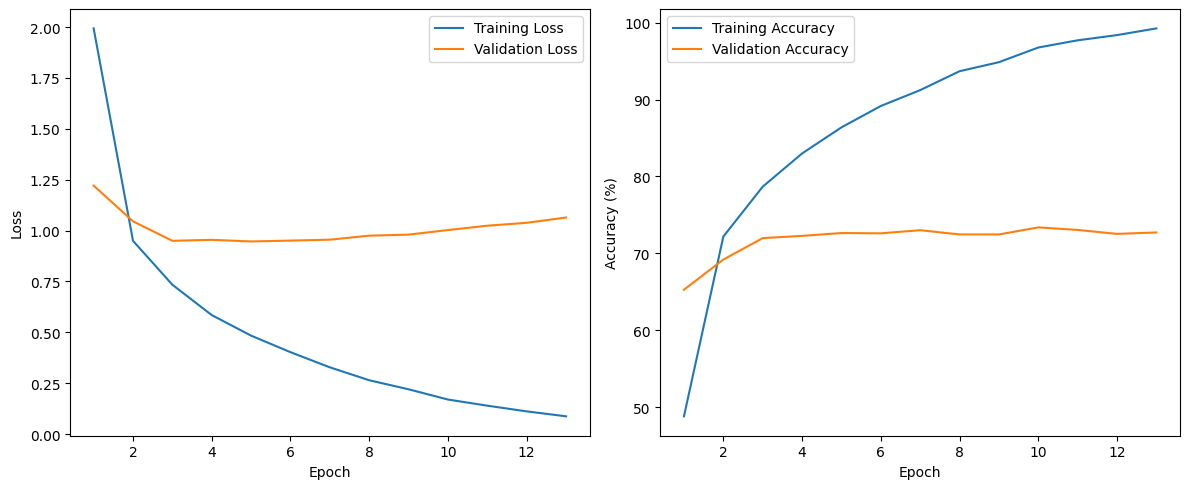

Validation Loss: 1.0027, Validation Accuracy: 73.38%
Current Best Accuracy: 73.38% with Hyperparameters: (0.001, 0.99)


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Training with LR: 0.001, Batch Size: 128, Gamma: 0.95
Epoch [1/15] - Training Loss: 1.9791, Training Accuracy: 48.00%
 - Validation Loss: 1.1976, Validation Accuracy: 64.94%
Model saved to /dinov2_model.pth.
Epoch [2/15] - Training Loss: 0.9341, Training Accuracy: 72.71%
 - Validation Loss: 1.0395, Validation Accuracy: 69.16%
Model saved to /dinov2_model.pth.
Epoch [3/15] - Training Loss: 0.7205, Training Accuracy: 79.12%
 - Validation Loss: 0.9781, Validation Accuracy: 71.80%
Model saved to /dinov2_model.pth.
Epoch [4/15] - Training Loss: 0.5904, Training Accuracy: 82.89%
 - Validation Loss: 0.9455, Validation Accuracy: 71.29%
Epoch [5/15] - Training Loss: 0.4786, Training Accuracy: 86.80%
 - Validation Loss: 0.9647, Validation Accuracy: 71.21%
Epoch [6/15] - Training Loss: 0.4165, Training Accuracy: 88.87%
 - Validation Loss: 0.9474, Validation Accuracy: 72.75%
Model saved to /dinov2_model.pth.
Epoch [7/15] - Training Loss: 0.3406, Training Accuracy: 91.37%
 - Validation Loss: 0.9534

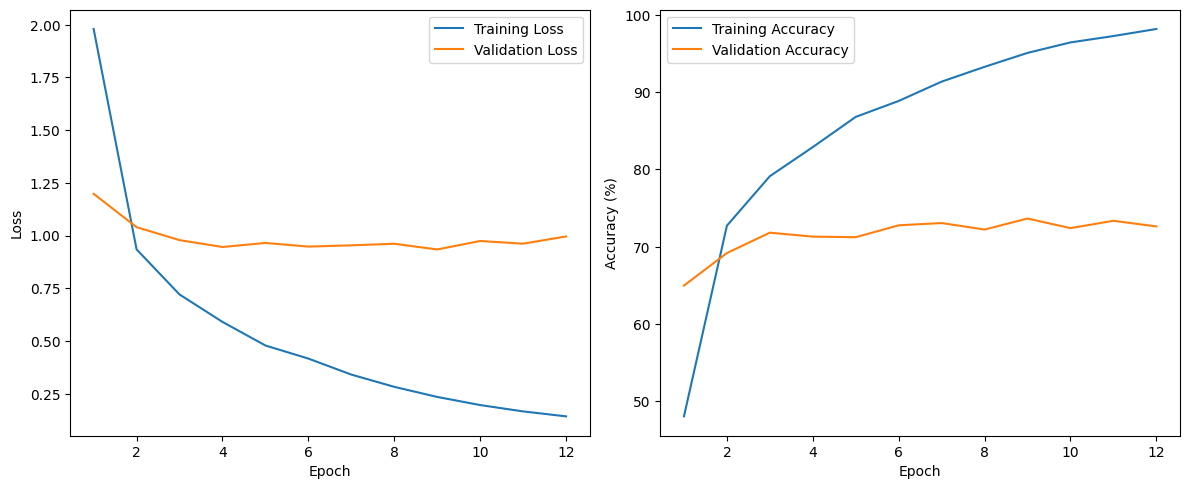

Validation Loss: 0.9338, Validation Accuracy: 73.63%
Current Best Accuracy: 73.63% with Hyperparameters: (0.001, 0.95)


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Training with LR: 0.0001, Batch Size: 128, Gamma: 0.99
Epoch [1/15] - Training Loss: 3.8853, Training Accuracy: 12.11%
 - Validation Loss: 3.3032, Validation Accuracy: 27.91%
Model saved to /dinov2_model.pth.
Epoch [2/15] - Training Loss: 2.7773, Training Accuracy: 38.99%
 - Validation Loss: 2.3715, Validation Accuracy: 47.41%
Model saved to /dinov2_model.pth.
Epoch [3/15] - Training Loss: 2.0359, Training Accuracy: 53.46%
 - Validation Loss: 1.8639, Validation Accuracy: 57.06%
Model saved to /dinov2_model.pth.
Epoch [4/15] - Training Loss: 1.6455, Training Accuracy: 61.23%
 - Validation Loss: 1.5847, Validation Accuracy: 61.20%
Model saved to /dinov2_model.pth.
Epoch [5/15] - Training Loss: 1.4026, Training Accuracy: 65.44%
 - Validation Loss: 1.4135, Validation Accuracy: 64.32%
Model saved to /dinov2_model.pth.
Epoch [6/15] - Training Loss: 1.2549, Training Accuracy: 68.70%
 - Validation Loss: 1.2957, Validation Accuracy: 67.11%
Model saved to /dinov2_model.pth.
Epoch [7/15] - Traini

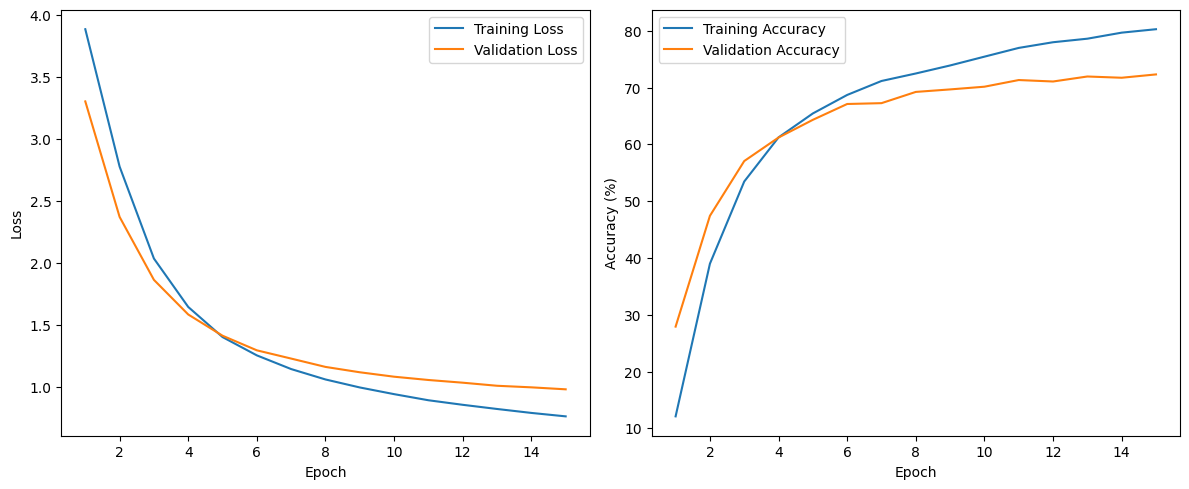

Validation Loss: 0.9812, Validation Accuracy: 72.31%
Current Best Accuracy: 73.63% with Hyperparameters: (0.001, 0.95)


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Training with LR: 0.0001, Batch Size: 128, Gamma: 0.95
Epoch [1/15] - Training Loss: 3.9407, Training Accuracy: 12.39%
 - Validation Loss: 3.3979, Validation Accuracy: 26.62%
Model saved to /dinov2_model.pth.
Epoch [2/15] - Training Loss: 2.8603, Training Accuracy: 37.80%
 - Validation Loss: 2.4600, Validation Accuracy: 45.65%
Model saved to /dinov2_model.pth.
Epoch [3/15] - Training Loss: 2.0974, Training Accuracy: 53.38%
 - Validation Loss: 1.9395, Validation Accuracy: 54.97%
Model saved to /dinov2_model.pth.
Epoch [4/15] - Training Loss: 1.6881, Training Accuracy: 60.88%
 - Validation Loss: 1.6601, Validation Accuracy: 59.66%
Model saved to /dinov2_model.pth.
Epoch [5/15] - Training Loss: 1.4605, Training Accuracy: 65.22%
 - Validation Loss: 1.4951, Validation Accuracy: 62.16%
Model saved to /dinov2_model.pth.
Epoch [6/15] - Training Loss: 1.3099, Training Accuracy: 67.68%
 - Validation Loss: 1.3861, Validation Accuracy: 64.69%
Model saved to /dinov2_model.pth.
Epoch [7/15] - Traini

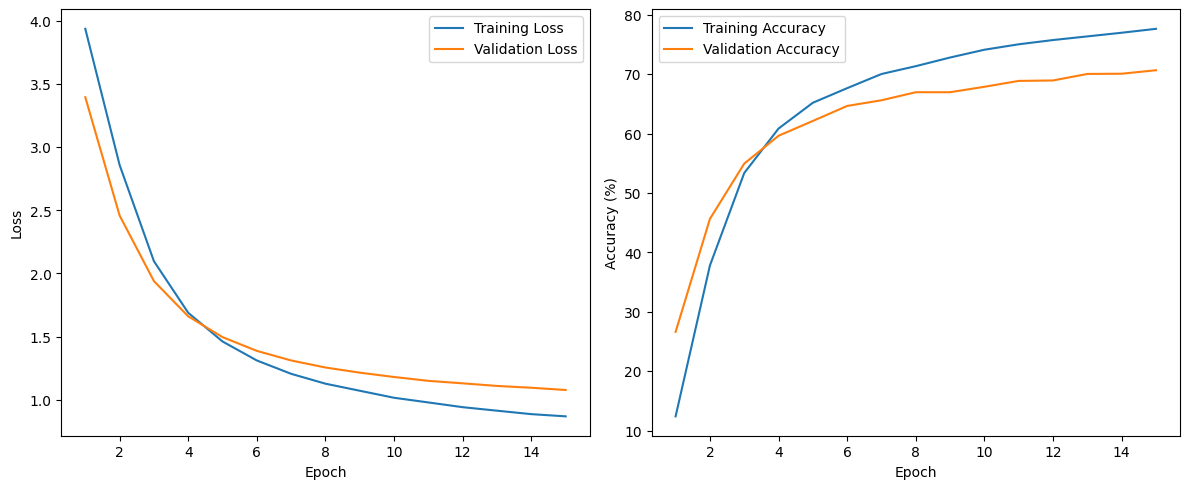

Validation Loss: 1.0759, Validation Accuracy: 70.70%
Current Best Accuracy: 73.63% with Hyperparameters: (0.001, 0.95)


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Training with LR: 0.0005, Batch Size: 128, Gamma: 0.99
Epoch [1/15] - Training Loss: 2.4894, Training Accuracy: 40.33%
 - Validation Loss: 1.4552, Validation Accuracy: 60.62%
Model saved to /dinov2_model.pth.
Epoch [2/15] - Training Loss: 1.1485, Training Accuracy: 68.38%
 - Validation Loss: 1.1194, Validation Accuracy: 68.21%
Model saved to /dinov2_model.pth.
Epoch [3/15] - Training Loss: 0.8916, Training Accuracy: 75.15%
 - Validation Loss: 1.0581, Validation Accuracy: 69.34%
Model saved to /dinov2_model.pth.
Epoch [4/15] - Training Loss: 0.7506, Training Accuracy: 79.26%
 - Validation Loss: 0.9653, Validation Accuracy: 71.40%
Model saved to /dinov2_model.pth.
Epoch [5/15] - Training Loss: 0.6555, Training Accuracy: 81.94%
 - Validation Loss: 0.9468, Validation Accuracy: 72.46%
Model saved to /dinov2_model.pth.
Epoch [6/15] - Training Loss: 0.5802, Training Accuracy: 84.10%
 - Validation Loss: 0.9350, Validation Accuracy: 72.42%
Epoch [7/15] - Training Loss: 0.5199, Training Accuracy

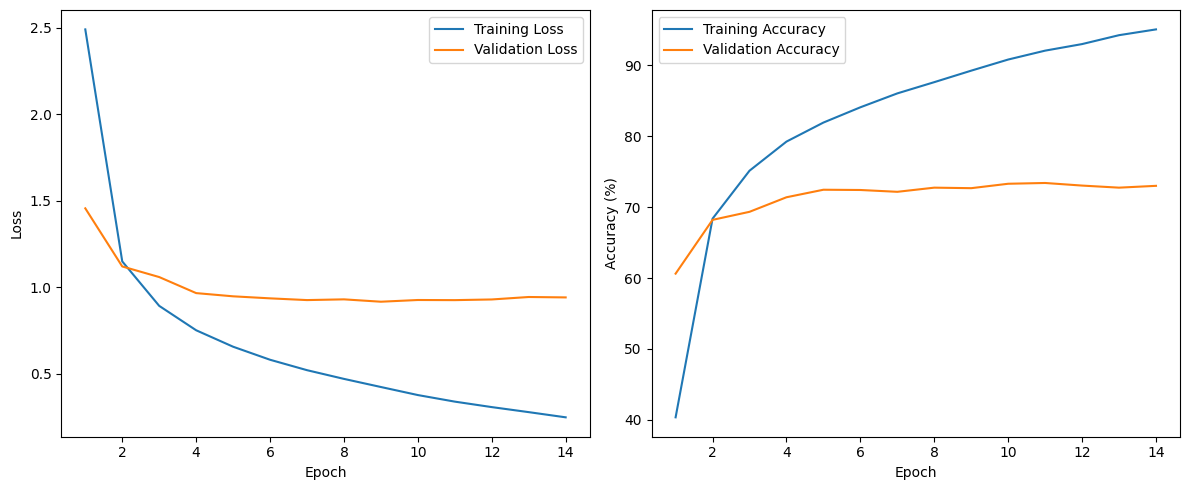

Validation Loss: 0.9247, Validation Accuracy: 73.41%
Current Best Accuracy: 73.63% with Hyperparameters: (0.001, 0.95)


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Training with LR: 0.0005, Batch Size: 128, Gamma: 0.95
Epoch [1/15] - Training Loss: 2.5439, Training Accuracy: 39.09%
 - Validation Loss: 1.4660, Validation Accuracy: 61.13%
Model saved to /dinov2_model.pth.
Epoch [2/15] - Training Loss: 1.1801, Training Accuracy: 67.06%
 - Validation Loss: 1.1251, Validation Accuracy: 68.35%
Model saved to /dinov2_model.pth.
Epoch [3/15] - Training Loss: 0.9033, Training Accuracy: 74.85%
 - Validation Loss: 1.0349, Validation Accuracy: 70.66%
Model saved to /dinov2_model.pth.
Epoch [4/15] - Training Loss: 0.7739, Training Accuracy: 78.22%
 - Validation Loss: 0.9716, Validation Accuracy: 72.02%
Model saved to /dinov2_model.pth.
Epoch [5/15] - Training Loss: 0.6797, Training Accuracy: 81.54%
 - Validation Loss: 0.9444, Validation Accuracy: 72.57%
Model saved to /dinov2_model.pth.
Epoch [6/15] - Training Loss: 0.6069, Training Accuracy: 83.74%
 - Validation Loss: 0.9295, Validation Accuracy: 72.79%
Model saved to /dinov2_model.pth.
Epoch [7/15] - Traini

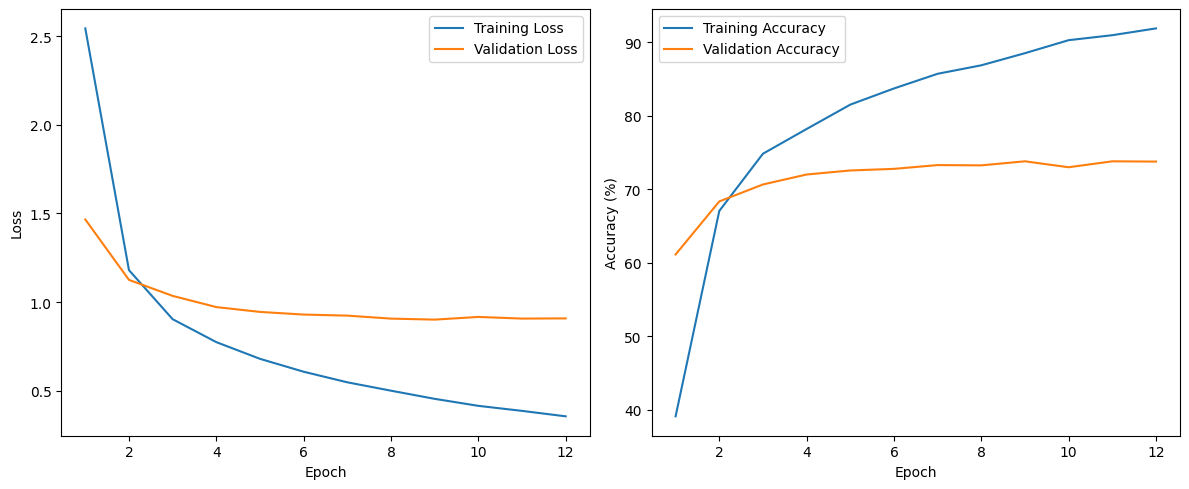

Validation Loss: 0.9009, Validation Accuracy: 73.82%
Current Best Accuracy: 73.82% with Hyperparameters: (0.0005, 0.95)
Final model results:
Best Hyperparameters: (0.0005, 0.95) with Validation Accuracy: 73.82%


In [ ]:
# Define the hyperparameter grid
learning_rates = [1e-3, 1e-4, 5e-4]
scheduler_gammas = [0.99, 0.95]

# Create a list of all possible hyperparameter combinations
hyperparameter_grid = list(itertools.product(learning_rates, scheduler_gammas))

best_accuracy = 0.0
best_hyperparameters = None

print_summary = True
for lr, gamma in hyperparameter_grid:

    # Initialize the model (ResNet or ViT)
    classifier = VitClassifier(
        model_path='/dinov2_model.pth',
        n_classes=74,
        criterion=torch.nn.CrossEntropyLoss(),
        lr=lr,
        batch_size=batch_size,
        scheduler_gamma=gamma,
    )

    if print_summary:
        print(summary(classifier.model, (3, 224, 224)))
        print_summary = False

    # Train the model
    print(f"Training with LR: {lr}, Batch Size: {batch_size}, Gamma: {gamma}")
    classifier.train(train_loader, validation_loader, n_epochs=15)

    # Evaluate the model on the validation set
    classifier.load_model()
    val_loss, val_accuracy = classifier.evaluate(validation_loader)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")



    # Check if this is the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_hyperparameters = (lr, gamma)

    print(f"Current Best Accuracy: {best_accuracy:.2f}% with Hyperparameters: {best_hyperparameters}")

print("Final model results:")
print(f"Best Hyperparameters: {best_hyperparameters} with Validation Accuracy: {best_accuracy:.2f}%")


## 17. Defining the `ResNetClassifier` Class for ResNet-50 Model

### Description
The `ResNetClassifier` class is a specific implementation of the `Classifier` base class tailored for the ResNet-50 model. This class focuses on fine-tuning a pre-trained ResNet-50 model.
### Class Breakdown:

- **`__init__` Method:**
  - **Parameters:**
    - `model_path` (str): Path to save/load the model.
    - `n_classes` (int): Number of output classes for the model.
    - `criterion` (torch.nn.Module): Loss function to optimize.
    - `lr` (float): Learning rate for the optimizer.
    - `batch_size` (int): Number of samples per batch.
    - `scheduler_gamma` (float): Gamma value for learning rate decay in the scheduler.

- **`init_model` Method:**
  - **Purpose:**
    - This method loads a pre-trained ResNet-50 model and modifies its final fully connected (fc) layer to match the number of output classes specified for the task.
    - **Implementation Details:**
      - **Loading the Model:** The `torchvision.models.resnet50` function is used to load a ResNet-50 model pre-trained on the ImageNet dataset.
      - **Modifying the Final Layer:** The final fully connected layer (`model.fc`) is replaced with a new linear layer that has the appropriate number of output features (`n_classes`).
      - **Weight Initialization:** The weights of the new fully connected layer are initialized using Xavier uniform initialization to ensure that the model starts training with properly scaled weights.





In [30]:


class ResNetClassifier(Classifier):
    def __init__(self, model_path, n_classes, criterion, lr, batch_size, scheduler_gamma):
        super(ResNetClassifier, self).__init__(model_path, n_classes, criterion, lr, batch_size, scheduler_gamma=scheduler_gamma)

    def init_model(self):
        # Load the pre-trained ResNet-50 model
        model = models.resnet50(pretrained=True)

        # Modify the final layer to match the number of classes
        model.fc = torch.nn.Linear(model.fc.in_features, self.n_classes)

        # Initialize the weights of the new layers
        torch.nn.init.xavier_uniform_(model.fc.weight)

        model = model.to(self.device)
        return model



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

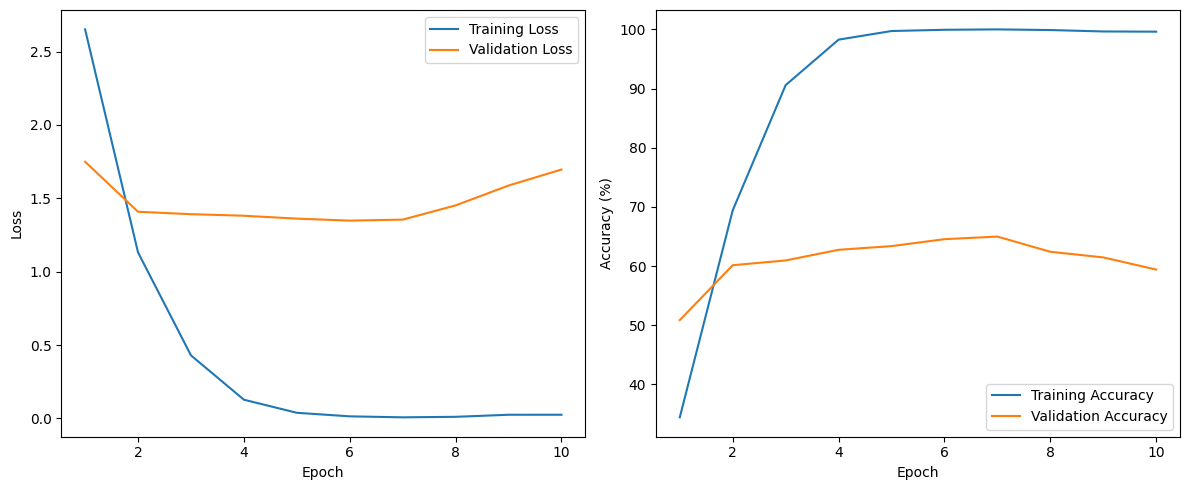

Validation Loss: 1.3547, Validation Accuracy: 64.98%
Test Loss: 1.3659, Test Accuracy: 63.51%
Current Best Accuracy: 64.98% with Hyperparameters: (0.0001, 0.99)
Training with LR: 0.0001, Batch Size: 128, Gamma: 0.95
Epoch [1/15] - Training Loss: 2.6320, Training Accuracy: 35.50%
 - Validation Loss: 1.7284, Validation Accuracy: 52.73%
Model saved to /resnet_model.pth.
Epoch [2/15] - Training Loss: 1.1053, Training Accuracy: 70.38%
 - Validation Loss: 1.4684, Validation Accuracy: 57.98%
Model saved to /resnet_model.pth.
Epoch [3/15] - Training Loss: 0.4366, Training Accuracy: 90.17%
 - Validation Loss: 1.4073, Validation Accuracy: 60.03%
Model saved to /resnet_model.pth.
Epoch [4/15] - Training Loss: 0.1349, Training Accuracy: 98.23%
 - Validation Loss: 1.3480, Validation Accuracy: 62.63%
Model saved to /resnet_model.pth.
Epoch [5/15] - Training Loss: 0.0361, Training Accuracy: 99.81%
 - Validation Loss: 1.3312, Validation Accuracy: 64.83%
Model saved to /resnet_model.pth.
Epoch [6/15] -

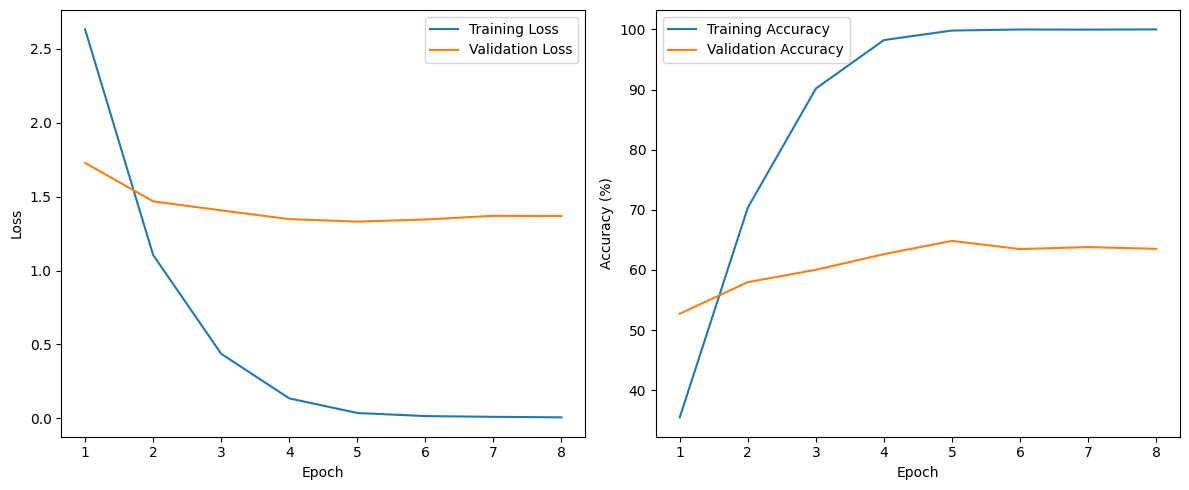

Validation Loss: 1.3312, Validation Accuracy: 64.83%
Test Loss: 1.3520, Test Accuracy: 64.26%
Current Best Accuracy: 64.98% with Hyperparameters: (0.0001, 0.99)
Training with LR: 0.0001, Batch Size: 128, Gamma: 0.9
Epoch [1/15] - Training Loss: 2.6621, Training Accuracy: 33.73%
 - Validation Loss: 1.7516, Validation Accuracy: 51.05%
Model saved to /resnet_model.pth.
Epoch [2/15] - Training Loss: 1.1402, Training Accuracy: 69.80%
 - Validation Loss: 1.4949, Validation Accuracy: 56.99%
Model saved to /resnet_model.pth.
Epoch [3/15] - Training Loss: 0.4581, Training Accuracy: 89.83%
 - Validation Loss: 1.3618, Validation Accuracy: 61.75%
Model saved to /resnet_model.pth.
Epoch [4/15] - Training Loss: 0.1402, Training Accuracy: 98.34%
 - Validation Loss: 1.3434, Validation Accuracy: 62.01%
Model saved to /resnet_model.pth.
Epoch [5/15] - Training Loss: 0.0451, Training Accuracy: 99.83%
 - Validation Loss: 1.3426, Validation Accuracy: 63.88%
Model saved to /resnet_model.pth.
Epoch [6/15] - 

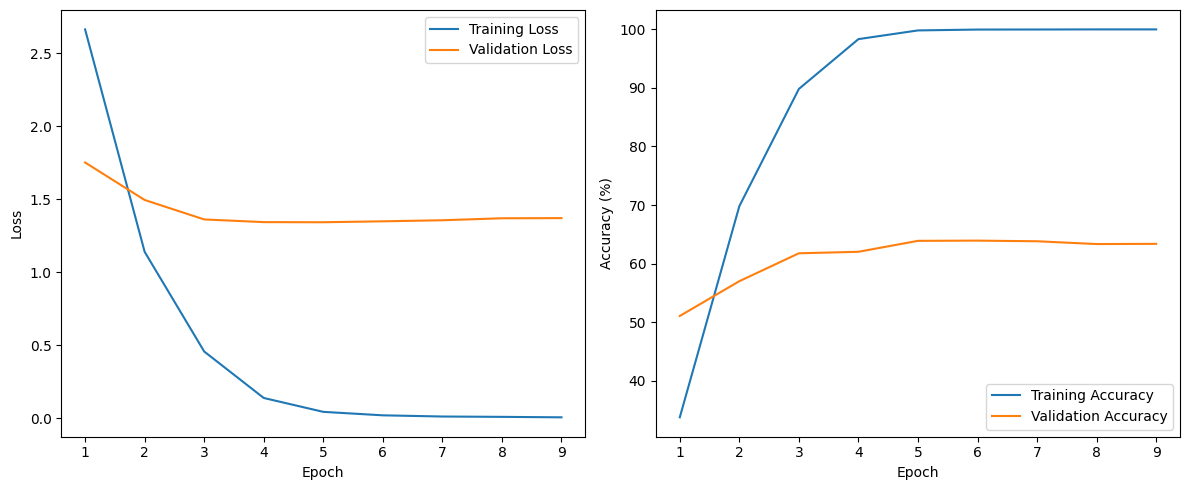

Validation Loss: 1.3489, Validation Accuracy: 63.92%
Test Loss: 1.3280, Test Accuracy: 64.21%
Current Best Accuracy: 64.98% with Hyperparameters: (0.0001, 0.99)
Training with LR: 0.0005, Batch Size: 128, Gamma: 0.99
Epoch [1/15] - Training Loss: 2.5110, Training Accuracy: 33.79%
 - Validation Loss: 2.1627, Validation Accuracy: 41.44%
Model saved to /resnet_model.pth.
Epoch [2/15] - Training Loss: 1.4992, Training Accuracy: 56.12%
 - Validation Loss: 1.9714, Validation Accuracy: 46.24%
Model saved to /resnet_model.pth.
Epoch [3/15] - Training Loss: 0.9824, Training Accuracy: 70.57%
 - Validation Loss: 2.4019, Validation Accuracy: 42.24%
Epoch [4/15] - Training Loss: 0.6418, Training Accuracy: 80.02%
 - Validation Loss: 1.9901, Validation Accuracy: 51.08%
Model saved to /resnet_model.pth.
Epoch [5/15] - Training Loss: 0.3803, Training Accuracy: 88.24%
 - Validation Loss: 2.1426, Validation Accuracy: 50.50%
Epoch [6/15] - Training Loss: 0.2634, Training Accuracy: 92.49%
 - Validation Loss

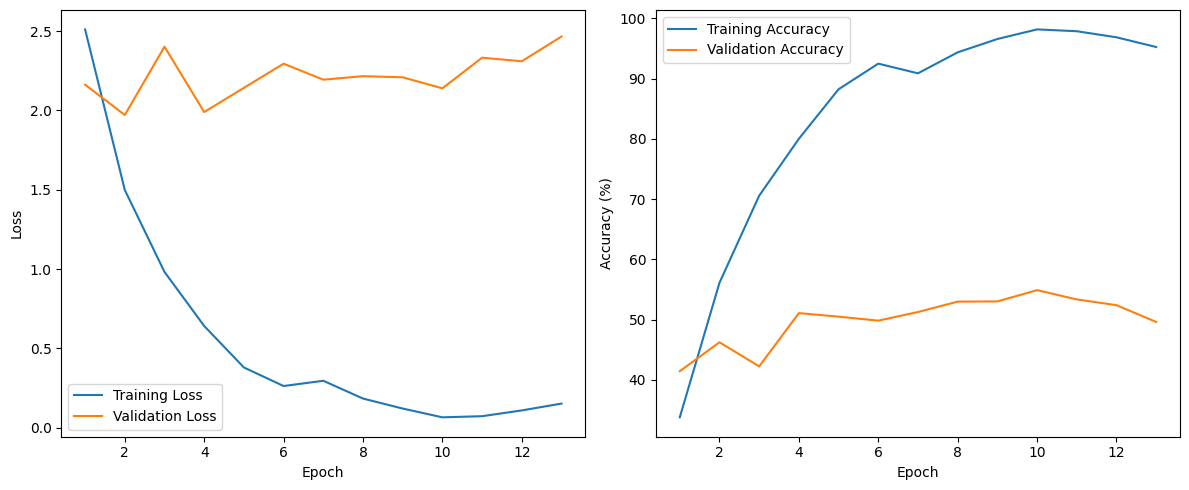

Validation Loss: 2.1395, Validation Accuracy: 54.90%
Test Loss: 2.0478, Test Accuracy: 55.37%
Current Best Accuracy: 64.98% with Hyperparameters: (0.0001, 0.99)
Training with LR: 0.0005, Batch Size: 128, Gamma: 0.95
Epoch [1/15] - Training Loss: 2.5095, Training Accuracy: 33.51%
 - Validation Loss: 2.3671, Validation Accuracy: 37.22%
Model saved to /resnet_model.pth.
Epoch [2/15] - Training Loss: 1.4468, Training Accuracy: 57.93%
 - Validation Loss: 2.0843, Validation Accuracy: 44.37%
Model saved to /resnet_model.pth.
Epoch [3/15] - Training Loss: 0.8967, Training Accuracy: 73.18%
 - Validation Loss: 1.9664, Validation Accuracy: 48.26%
Model saved to /resnet_model.pth.
Epoch [4/15] - Training Loss: 0.5386, Training Accuracy: 84.01%
 - Validation Loss: 1.8720, Validation Accuracy: 52.07%
Model saved to /resnet_model.pth.
Epoch [5/15] - Training Loss: 0.3257, Training Accuracy: 90.00%
 - Validation Loss: 1.9328, Validation Accuracy: 53.10%
Model saved to /resnet_model.pth.
Epoch [6/15] -

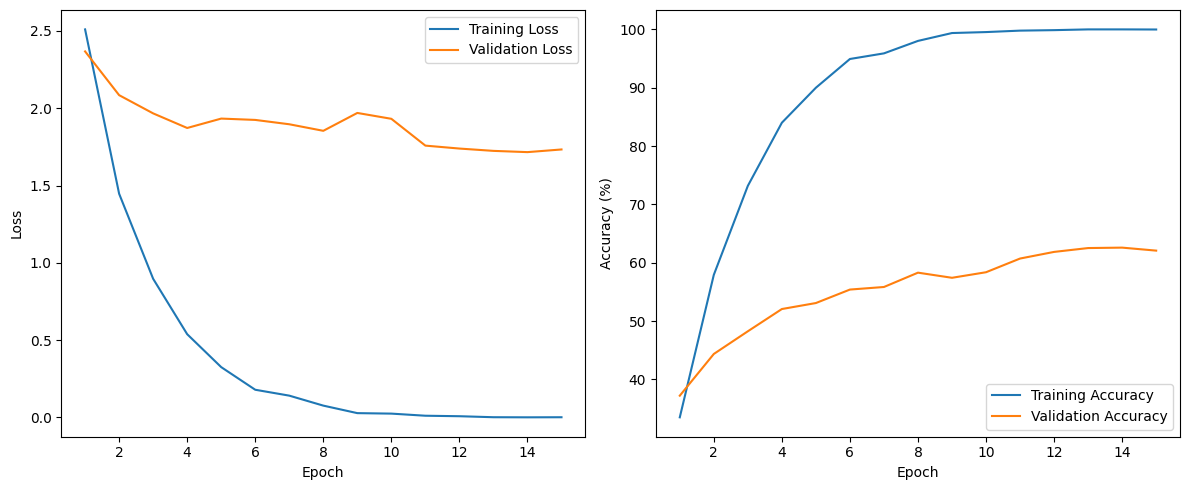

Validation Loss: 1.7159, Validation Accuracy: 62.60%
Test Loss: 1.7408, Test Accuracy: 63.63%
Current Best Accuracy: 64.98% with Hyperparameters: (0.0001, 0.99)
Training with LR: 0.0005, Batch Size: 128, Gamma: 0.9
Epoch [1/15] - Training Loss: 2.4891, Training Accuracy: 34.52%
 - Validation Loss: 2.1781, Validation Accuracy: 39.93%
Model saved to /resnet_model.pth.
Epoch [2/15] - Training Loss: 1.4145, Training Accuracy: 58.74%
 - Validation Loss: 1.9701, Validation Accuracy: 46.79%
Model saved to /resnet_model.pth.
Epoch [3/15] - Training Loss: 0.8384, Training Accuracy: 74.99%
 - Validation Loss: 1.8401, Validation Accuracy: 50.53%
Model saved to /resnet_model.pth.
Epoch [4/15] - Training Loss: 0.4198, Training Accuracy: 87.55%
 - Validation Loss: 1.9139, Validation Accuracy: 53.36%
Model saved to /resnet_model.pth.
Epoch [5/15] - Training Loss: 0.1961, Training Accuracy: 94.67%
 - Validation Loss: 1.7577, Validation Accuracy: 58.23%
Model saved to /resnet_model.pth.
Epoch [6/15] - 

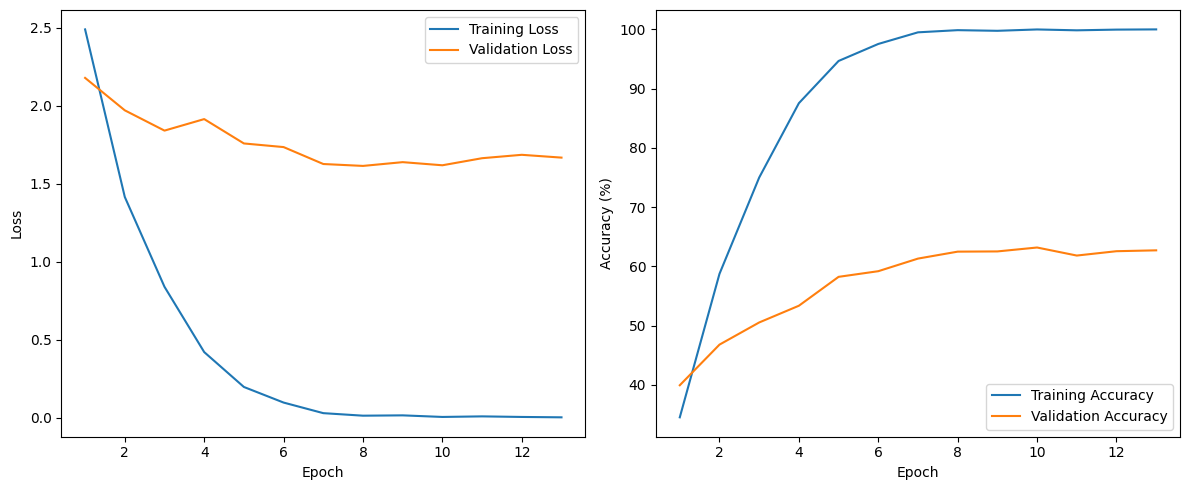

Validation Loss: 1.6178, Validation Accuracy: 63.18%
Test Loss: 1.5996, Test Accuracy: 62.58%
Current Best Accuracy: 64.98% with Hyperparameters: (0.0001, 0.99)
Final model results:
Best Hyperparameters: (0.0001, 0.99) with Validation Accuracy: 64.98%


In [ ]:
# Define the hyperparameter grid
learning_rates = [1e-4, 5e-4]
scheduler_gammas = [0.99, 0.95, 0.9]  # Start with a range and fine-tune based on results

# Create a list of all possible hyperparameter combinations
hyperparameter_grid = list(itertools.product(learning_rates, scheduler_gammas))

best_accuracy = 0.0
best_hyperparameters = None

print_summary = True
for lr, gamma in hyperparameter_grid:

    # Initialize the ResNet classifier
    classifier = ResNetClassifier(
        model_path='/resnet_model.pth',
        n_classes=74,
        criterion=torch.nn.CrossEntropyLoss(),
        lr=lr,
        batch_size=batch_size,
        scheduler_gamma=gamma,
    )

    # Replace the default scheduler with ExponentialLR
    classifier.scheduler = ExponentialLR(classifier.optimizer, gamma=gamma)

    if print_summary:
        print(summary(classifier.model, (3, 224, 224)))
        print_summary = False

    # Train the model
    print(f"Training with LR: {lr}, Batch Size: {batch_size}, Gamma: {gamma}")
    classifier.train(train_loader, validation_loader, n_epochs=15)

    # Evaluate the model on the validation set
    classifier.load_model()
    val_loss, val_accuracy = classifier.evaluate(validation_loader)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Evaluate the model on the test set
    test_loss, test_accuracy = classifier.evaluate(test_dataloader)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Check if this is the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_hyperparameters = (lr, gamma)

    print(f"Current Best Accuracy: {best_accuracy:.2f}% with Hyperparameters: {best_hyperparameters}")

print("Final model results:")
print(f"Best Hyperparameters: {best_hyperparameters} with Validation Accuracy: {best_accuracy:.2f}%")


## 19. Combining Training and Validation Datasets and Updating DataLoaders

### Description
In this section, the training and validation datasets are combined into a single dataset.



In [31]:
from torch.utils.data import ConcatDataset

#combining validation and train

train_data_set = ConcatDataset([train_dataset, validation_dataset])
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)


## 20. Evaluating Model Performance with Top-1, Top-3, and Top-5 Accuracies

### Description
The `evaluate_model` function is designed to assess the performance of a PyTorch model by computing the Top-1, Top-3, and Top-5 accuracies. These metrics are particularly useful for evaluating models on tasks with multiple classes, where it's valuable to know how often the correct label is among the top predictions.

### Function Breakdown:

- **Function `evaluate_model`:**
  - **Parameters:**
    - `model`: The PyTorch model to be evaluated. This model should be trained and ready for inference.
    - `dataloader`: A PyTorch DataLoader that provides the data for evaluation. The data should be organized into batches.
    - `device`: The device used for computation (e.g., 'cuda' for GPU or 'cpu' for CPU).
  - **Returns:**
    - A tuple containing three accuracy metrics:
      - **`top1_accuracy`:** The percentage of samples for which the top predicted label matches the true label.
      - **`top3_accuracy`:** The percentage of samples for which the true label is within the top three predicted labels.
      - **`top5_accuracy`:** The percentage of samples for which the true label is within the top five predicted labels.


### Purpose:
- **Comprehensive Model Evaluation:** While Top-1 accuracy is the most common metric, Top-3 and Top-5 accuracies provide additional insight, especially in tasks where identifying a set of likely labels is valuable. For example, in multi-class classification tasks with many similar classes, it's useful to know if the correct label is among the top predictions even if it's not the highest-scoring one.




In [ ]:
def evaluate_model(model, dataloader, device):
    """
    Evaluates a model on a given dataloader and computes top-1, top-3, and top-5 accuracies.

    Args:
        model: The PyTorch model to evaluate.
        dataloader: The DataLoader containing the data.
        device: The device to use for computation (e.g., 'cuda' or 'cpu').

    Returns:
        A tuple containing:
            - top1_accuracy: Top-1 accuracy.
            - top3_accuracy: Top-3 accuracy.
            - top5_accuracy: Top-5 accuracy.
    """

    model.eval()  # Set the model to evaluation mode
    correct_1 = 0
    correct_3 = 0
    correct_5 = 0
    total = 0

    with torch.no_grad():  # No need to calculate gradients during evaluation
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.sort(outputs.data, dim=1, descending=True)

            # Top-1 accuracy
            correct_1 += (predicted[:, 0] == labels).sum().item()

            # Top-3 accuracy
            for i in range(labels.size(0)):
                if labels[i] in predicted[i, :3]:
                    correct_3 += 1

            # Top-5 accuracy
            for i in range(labels.size(0)):
                if labels[i] in predicted[i, :5]:
                    correct_5 += 1

            total += labels.size(0)

    top1_accuracy = 100 * correct_1 / total
    top3_accuracy = 100 * correct_3 / total
    top5_accuracy = 100 * correct_5 / total

    return top1_accuracy, top3_accuracy, top5_accuracy



## 21. Final Model Training and Evaluation: ViT and ResNet-50

### Description
In this section, the final models (ViT and ResNet-50) are trained and evaluated using the best hyperparameters identified earlier. The models are evaluated on the test set to compute Top-1, Top-3, and Top-5 accuracies, providing a comprehensive assessment of their performance.








Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 16, 16]         226,176
          Identity-2             [-1, 256, 384]               0
        PatchEmbed-3             [-1, 256, 384]               0
         LayerNorm-4             [-1, 257, 384]             768
            Linear-5            [-1, 257, 1152]         443,520
           Dropout-6          [-1, 6, 257, 257]               0
            Linear-7             [-1, 257, 384]         147,840
           Dropout-8             [-1, 257, 384]               0
   MemEffAttention-9             [-1, 257, 384]               0
       LayerScale-10             [-1, 257, 384]               0
        LayerNorm-11             [-1, 257, 384]             768
           Linear-12            [-1, 257, 1536]         591,360
             GELU-13            [-1, 257, 1536]               0
          Dropout-14            [-1, 25

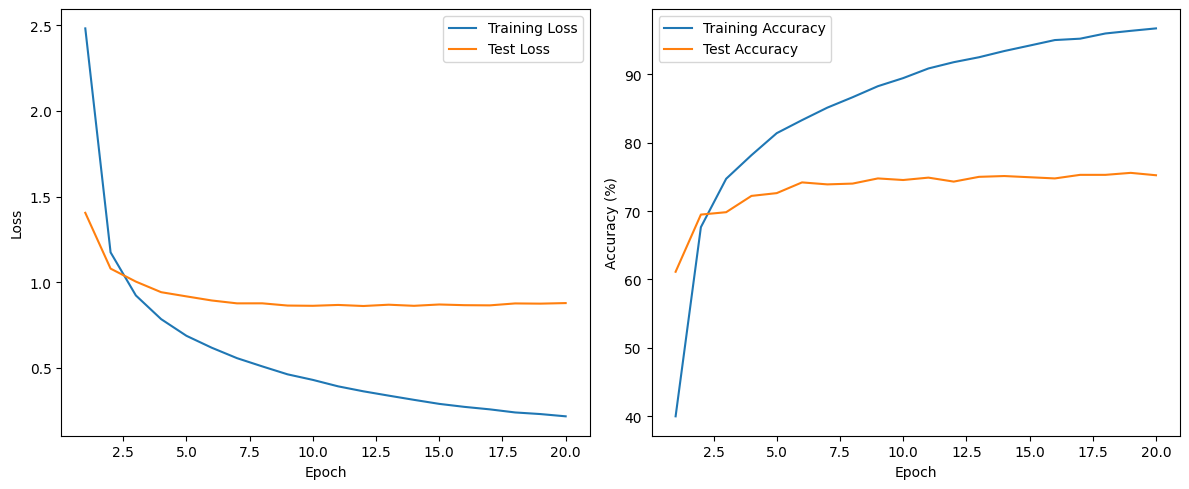

dinov2 final results
Top-1 Accuracy: 75.60%
Top-3 Accuracy: 89.66%
Top-5 Accuracy: 93.61%


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

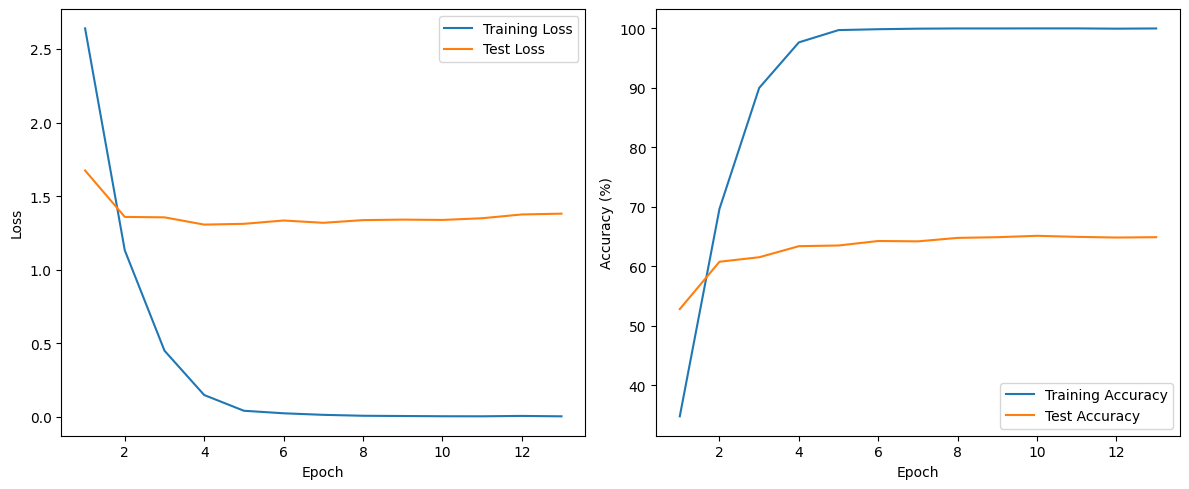

resnet final results
Top-1 Accuracy: 65.14%
Top-3 Accuracy: 83.32%
Top-5 Accuracy: 88.79%


In [ ]:
lr = 5e-4
gamma = 0.95

classifier = VitClassifier(
    model_path='/dinov2_model.pth',
    n_classes=74,
    criterion=torch.nn.CrossEntropyLoss(),
    lr=lr,
    batch_size=batch_size,
    scheduler_gamma=gamma,
)

print(summary(classifier.model, (3, 224, 224)))

classifier.train(train_dataloader, test_dataloader, n_epochs=20, mode='train-test')


classifier.load_model()

top1, top3, top5 = evaluate_model(classifier.model, test_dataloader, device)
print('dinov2 final results')
print(f"Top-1 Accuracy: {top1:.2f}%")
print(f"Top-3 Accuracy: {top3:.2f}%")
print(f"Top-5 Accuracy: {top5:.2f}%")

lr = 1e-4
gamma = 0.99
classifier = ResNetClassifier(
    model_path='/resnet50_model.pth',
    n_classes=74,
    criterion=torch.nn.CrossEntropyLoss(),
    lr=lr,
    batch_size=batch_size,
    scheduler_gamma=gamma,
)

print(summary(classifier.model, (3, 224, 224)))

classifier.train(train_dataloader, test_dataloader, n_epochs=20, mode='train-test')


classifier.load_model()

top1, top3, top5 = evaluate_model(classifier.model, test_dataloader, device)
print('resnet final results')
print(f"Top-1 Accuracy: {top1:.2f}%")
print(f"Top-3 Accuracy: {top3:.2f}%")
print(f"Top-5 Accuracy: {top5:.2f}%")




In [36]:
transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop((image_dim, image_dim), scale=(0.8, 1.0), antialias=True),
    # transforms.RandomGrayscale(p=0.1),
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
    # transforms.RandomPerspective(distortion_scale=0.3, p=0.2),
])

In [37]:
train_dataset = Dataset_receiver(csv_train, "train", device, transformation, class_id, transform_aug)
test_dataset = Dataset_receiver(csv_test, "test", device, transformation, class_id)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)

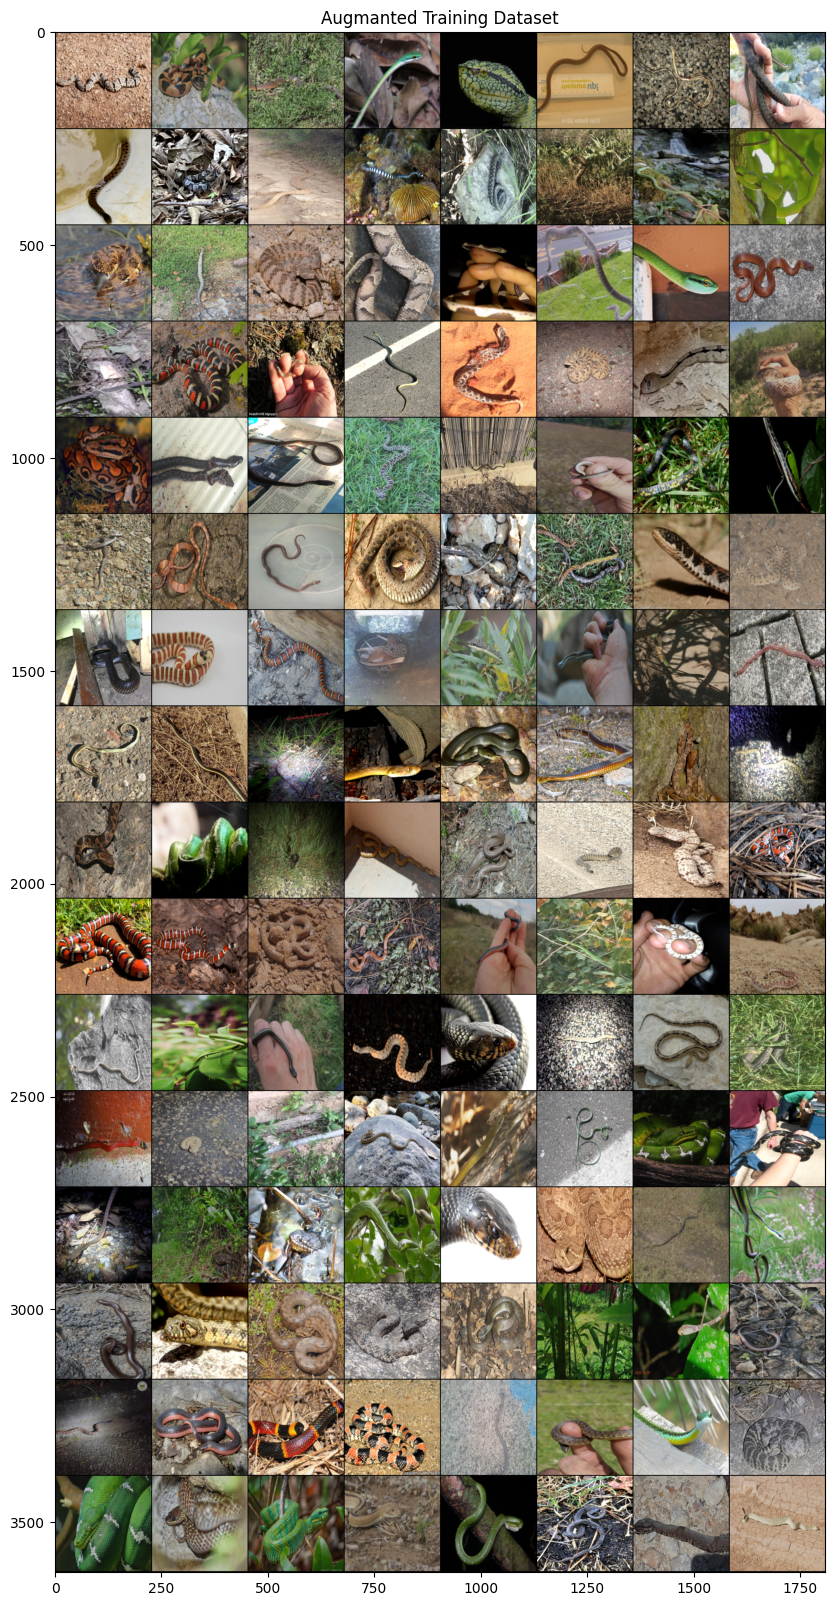

torch.Size([128, 3, 224, 224])
tensor([25, 45,  5, 46, 73, 54,  7, 68, 17,  0, 27, 44, 17, 30, 72, 72, 52,  1,
        29,  0, 40,  4, 46, 61, 59, 42, 65, 33, 38, 24,  7,  3, 36, 49, 31, 22,
        33, 71,  4, 32, 21,  9, 49, 38, 52,  4, 17, 24,  5, 42, 43, 13, 16, 67,
        48, 54, 67, 50,  8,  8, 63,  5,  1,  3, 45, 19,  1, 58, 15, 30, 25, 14,
        43, 42, 39, 61, 12, 47, 57, 57, 16,  2, 70, 24, 35, 23,  7,  5, 54, 28,
        16, 63, 63, 48, 19, 41,  8, 22, 53, 37, 35, 30, 50, 47, 15, 21, 21, 25,
        31,  2, 40, 17, 36, 12, 51, 62, 71,  4, 47, 29, 19, 49, 72,  7, 72, 52,
         1, 28])
torch.Size([128])
tensor([175, 373,  52, 381, 741, 485,  65, 690, 140,  18, 185, 368, 140, 193,
        740, 740, 470,  20, 189,  18, 338,  48, 381, 619, 560, 360, 672, 216,
        321, 168,  65,  39, 263, 396, 195, 163, 216, 738,  48, 215, 162,  73,
        396, 321, 470,  48, 140, 168,  52, 360, 364, 113, 135, 686, 384, 485,
        686, 427,  71,  71, 634,  52,  20,  39, 373, 158,  20,

In [39]:
a,clas = next(iter(train_dataloader))
b = denormalize_batch(a, mean, std)
original_class = torch.tensor([class_original[int(i)] for i in clas])
plt.figure(figsize=(20,20))
plt.title("Augmanted Training Dataset")
plt.imshow(torch.swapdims(torch.swapdims(vutils(b,8,2),0,2),0,1))
plt.show()
print(a.shape)

print(clas)
print(clas.shape)

print(original_class)
print(original_class.shape)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:01<00:00, 72.3MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 16, 16]         226,176
          Identity-2             [-1, 256, 384]               0
        PatchEmbed-3             [-1, 256, 384]               0
         LayerNorm-4             [-1, 257, 384]             768
            Linear-5            [-1, 257, 1152]         443,520
           Dropout-6          [-1, 6, 257, 257]               0
            Linear-7             [-1, 257, 384]         147,840
           Dropout-8             [-1, 257, 384]               0
   MemEffAttention-9             [-1, 257, 384]               0
       LayerScale-10             [-1, 257, 384]               0
        LayerNorm-11             [-1, 257, 384]             768
           Linear-12            [-1, 257, 1536]         591,360
             GELU-13            [-1, 257, 1536]               0
          Dropout-14            [-1, 25

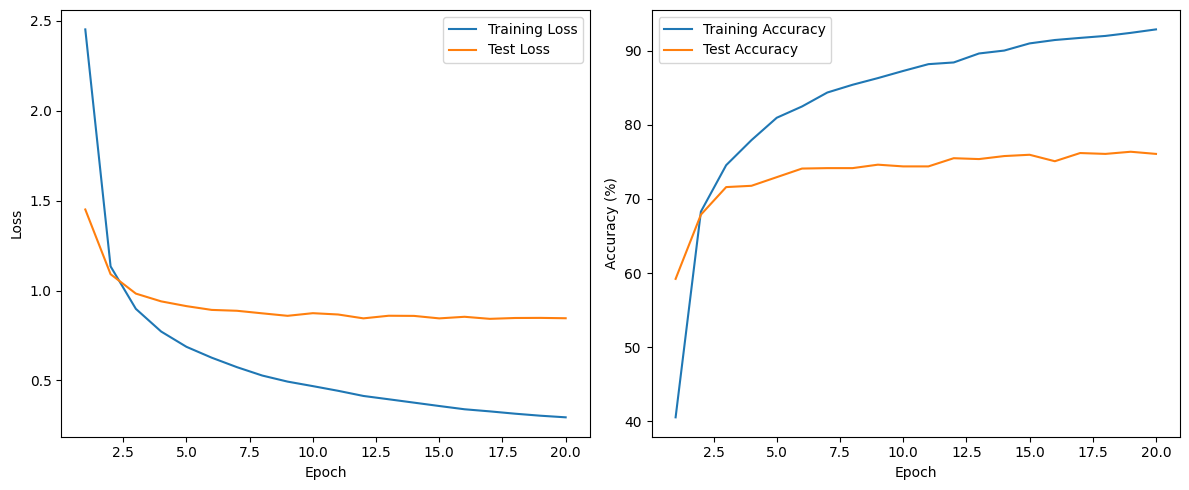

dinov2 final results
Top-1 Accuracy: 76.35%
Top-3 Accuracy: 90.47%
Top-5 Accuracy: 93.72%


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 116MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

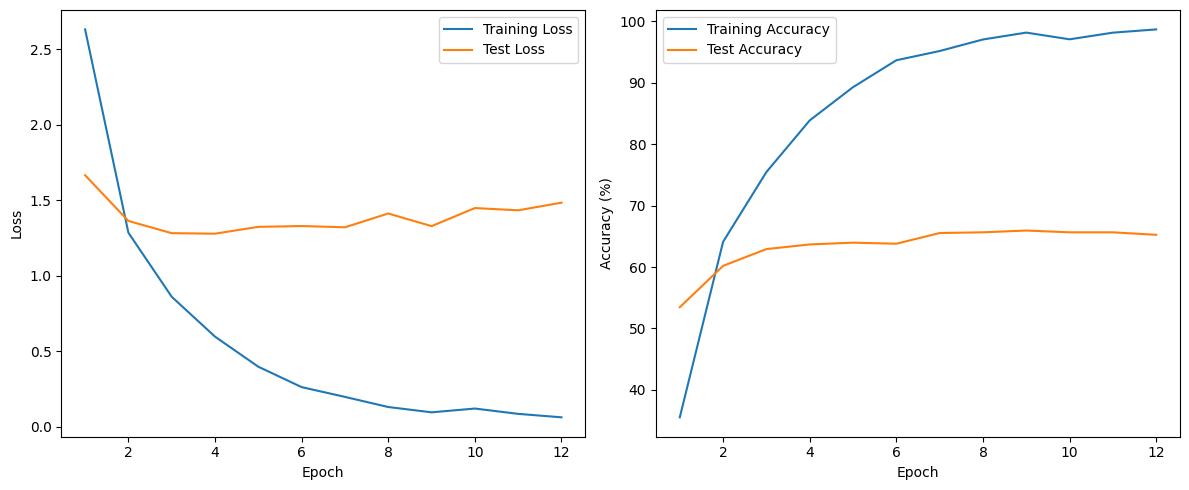

resnet final results
Top-1 Accuracy: 65.95%
Top-3 Accuracy: 84.43%
Top-5 Accuracy: 89.42%


In [ ]:
lr = 5e-4
gamma = 0.95

classifier = VitClassifier(
    model_path='/dinov2_model.pth',
    n_classes=74,
    criterion=torch.nn.CrossEntropyLoss(),
    lr=lr,
    batch_size=batch_size,
    scheduler_gamma=gamma,
)

print(summary(classifier.model, (3, 224, 224)))

classifier.train(train_dataloader, test_dataloader, n_epochs=20, mode='train-test')


classifier.load_model()

top1, top3, top5 = evaluate_model(classifier.model, test_dataloader, device)
print('dinov2 final results')
print(f"Top-1 Accuracy: {top1:.2f}%")
print(f"Top-3 Accuracy: {top3:.2f}%")
print(f"Top-5 Accuracy: {top5:.2f}%")

lr = 1e-4
gamma = 0.99
classifier = ResNetClassifier(
    model_path='/resnet50_model.pth',
    n_classes=74,
    criterion=torch.nn.CrossEntropyLoss(),
    lr=lr,
    batch_size=batch_size,
    scheduler_gamma=gamma,
)

print(summary(classifier.model, (3, 224, 224)))

classifier.train(train_dataloader, test_dataloader, n_epochs=20, mode='train-test')


classifier.load_model()

top1, top3, top5 = evaluate_model(classifier.model, test_dataloader, device)
print('resnet final results')
print(f"Top-1 Accuracy: {top1:.2f}%")
print(f"Top-3 Accuracy: {top3:.2f}%")
print(f"Top-5 Accuracy: {top5:.2f}%")




### Final Model Performance Comparison with and without Augmentation

## Overview
This section presents the comprehensive evaluation results of the **ResNet-50** and **Vision Transformer (ViT) - DINOv2** models, both before and after applying data augmentation. The models were assessed on a test dataset using Top-1, Top-3, and Top-5 accuracy metrics. These metrics provide insight into the models' effectiveness in correctly identifying the true class either as the top prediction or within the top few predictions.

## Results Without Augmentation

### ResNet-50:
- **Top-1 Accuracy:** 65.14%
- **Top-3 Accuracy:** 83.32%
- **Top-5 Accuracy:** 88.79%

### ViT - DINOv2:
- **Top-1 Accuracy:** 75.60%
- **Top-3 Accuracy:** 89.66%
- **Top-5 Accuracy:** 93.61%

## Results After Applying Augmentation

### ResNet-50:
- **Top-1 Accuracy:** 65.95% (Increase of 0.81%)
- **Top-3 Accuracy:** 84.43% (Increase of 1.11%)
- **Top-5 Accuracy:** 89.42% (Increase of 0.63%)

### ViT - DINOv2:
- **Top-1 Accuracy:** 76.35% (Increase of 0.75%)
- **Top-3 Accuracy:** 90.47% (Increase of 0.81%)
- **Top-5 Accuracy:** 93.72% (Increase of 0.11%)

## Interpretation and Analysis

### Overall Performance:
- **ViT - DINOv2** consistently outperformed **ResNet-50** across all metrics, both with and without augmentation. The Vision Transformer model demonstrated a superior ability to identify the correct class, particularly as the top prediction (Top-1 accuracy).

### Impact of Augmentation:
- **ViT - DINOv2**: The application of data augmentation led to a mild improvement in performance. The Top-1 accuracy saw a 0.75% increase, indicating a slight enhancement in the model's ability to make the correct prediction on the first attempt. The improvements in Top-3 and Top-5 accuracies were similarly modest, suggesting that while augmentations were beneficial, their impact on this advanced architecture was relatively minor.

- **ResNet-50**: Although ResNet-50 also saw only a mild improvement from the augmentations, the increase was slightly more pronounced than that of ViT - DINOv2. The Top-1 accuracy improved by 0.81%, with the Top-3 and Top-5 accuracies increasing by 1.11% and 0.63%, respectively. 

### Key Takeaways:
- **Model Selection**: The **ViT - DINOv2** model remains the superior choice for this classification task, consistently achieving higher accuracy metrics compared to ResNet-50.

- **Effectiveness of Augmentation**: While both models benefited from data augmentation, the gains were mild overall. **ResNet-50** showed slightly better improvement from augmentations than ViT - DINOv2.

- **Future Work:**
  - **Augmentation Exploration:** To fully leverage the potential of data augmentation, it is necessary to further explore and experiment with different augmentation techniques. This includes testing various combinations, intensities, and types of augmentations tailored to the specific characteristics of the dataset. By refining the augmentation strategy, it may be possible to achieve more significant improvements in model performance.
  - **Model Variants:** In addition to refining augmentation techniques, it will be crucial to compare the larger variants of these models. Larger versions of ResNet (e.g., ResNet-101 or ResNet-152) and Vision Transformers with more parameters or layers could potentially offer better performance and may respond differently to augmentation strategies. This comparison could provide deeper insights into the scalability and robustness of these models across different datasets and tasks.

